In [1]:
import torch
import pandas as pd 
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader 
import torch.nn as nn 
import torch.optim as optim
import matplotlib.pyplot as plt 

In [2]:
imgs = pd.read_csv("D:\\machine_learning\\Data\\fmnist_small.csv")

In [3]:
torch.manual_seed(42)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
device

device(type='cuda')

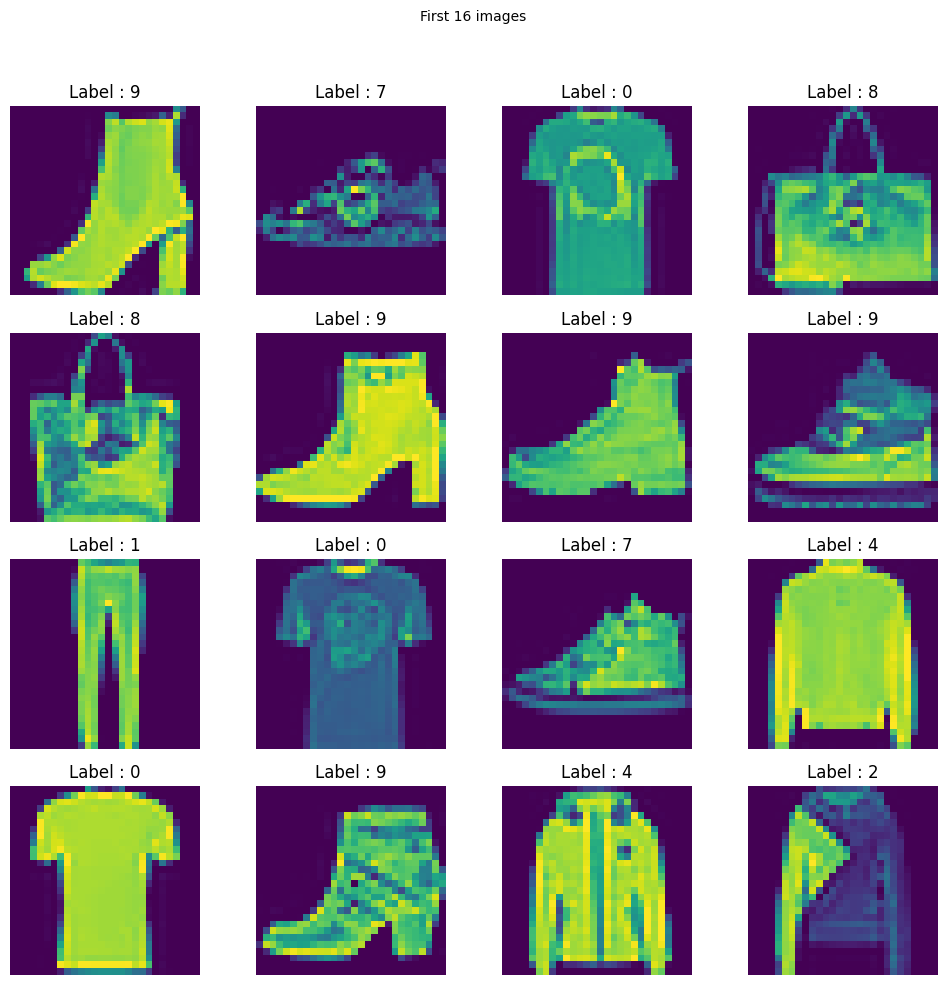

In [5]:
fig ,axes = plt.subplots(4,4, figsize=(10,10))

fig.suptitle("First 16 images",fontsize=10)

for i , ax in enumerate(axes.flat):
    img = imgs.iloc[i,1:].values.reshape(28,28)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Label : {imgs.iloc[i,0]}')

plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

In [7]:
imgs.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,...,0,7,0,50,205,196,213,165,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,142,142,142,21,0,3,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,213,203,174,151,188,10,0,0,0,0


In [6]:
X = imgs.iloc[:,1:].values
y = imgs.iloc[:,0].values

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle=True,test_size=0.2,random_state=42)

In [8]:
X_train = X_train/255.0
X_test = X_test/255.0 

In [9]:
class CustomData(Dataset):
    def __init__(self,features,labels):
        self.features = torch.tensor(features,dtype=torch.float32)
        self.labels = torch.tensor(labels,dtype=torch.long)
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, index):
        return self.features[index] , self.labels[index]
    

In [10]:
train_dataset = CustomData(X_train,y_train)

In [11]:
test_dataset = CustomData(X_test,y_test)

In [12]:
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True,pin_memory=True)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=True,pin_memory=True)

In [17]:
class MyModel(nn.Module):
    def __init__(self,num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features,392),
            nn.BatchNorm1d(392),
            nn.ReLU(),
            nn.Dropout(p=0.1),

            nn.Linear(392,196),
            nn.BatchNorm1d(196),
            nn.ReLU(),
            nn.Dropout(p=0.1),

            nn.Linear(196,98),
            nn.BatchNorm1d(98),
            nn.ReLU(),
            nn.Dropout(p=0.1),

            nn.Linear(98,49),
            nn.BatchNorm1d(49),
            nn.ReLU(),
            nn.Dropout(p=0.10),

            nn.Linear(49,24),
            nn.BatchNorm1d(24),
            nn.ReLU(),
            nn.Dropout(p=0.10),

            nn.Linear(24,10)
        )

    def forward(self,x):
        return self.model(x)




In [31]:
lr = 0.005
epochs = 100

In [30]:
model = MyModel(X_train.shape[1])
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=lr,weight_decay=1.5e-5)

In [32]:
for epoch in range(0,epochs):
    total_epoch_loss = 0 

    for batch_feature , batch_label in train_loader:
         batch_feature , batch_label =  batch_feature.to(device) , batch_label.to(device)

         output = model(batch_feature)

         loss = criterion(output,batch_label)

         optimizer.zero_grad()
         loss.backward()

         optimizer.step()

         total_epoch_loss = total_epoch_loss + loss.item()
    if epoch %10==0:    
          avg_loss = total_epoch_loss / len(train_loader)
          print(f'epoch: {epoch + 1} , loss: {avg_loss}')

epoch: 1 , loss: 1.0717600639661153
epoch: 11 , loss: 0.4176890557010969
epoch: 21 , loss: 0.31846032773454985
epoch: 31 , loss: 0.2624061166246732
epoch: 41 , loss: 0.22139792419970036
epoch: 51 , loss: 0.18302833778162797
epoch: 61 , loss: 0.17772066817929347
epoch: 71 , loss: 0.16487550023943187
epoch: 81 , loss: 0.14772918533844254
epoch: 91 , loss: 0.1467714973477026


In [33]:
model.eval()

total = 0 
correct = 0

for batch_feature , batch_label in test_loader:
     batch_feature , batch_label =  batch_feature.to(device) , batch_label.to(device)

     output = model(batch_feature)

     _,predicted = torch.max(output,1)

     total = total + batch_feature.shape[0]
     correct = correct + (predicted==batch_label).sum().item()
print(correct/total)

0.8333333333333334


In [34]:
model.eval()

total = 0 
correct = 0
with torch.no_grad():
     for batch_feature , batch_label in train_loader:
          batch_feature , batch_label =  batch_feature.to(device) , batch_label.to(device)

          output = model(batch_feature)

          _,predicted = torch.max(output,1)

          total = total + batch_feature.shape[0]
          correct = correct + (predicted==batch_label).sum().item()
     print(correct/total)

0.9879166666666667
